In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import seaborn as sns
import os
sns.set_style("whitegrid")
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense


In [9]:
# base_dir = 'd:/GitHub/python-2-work/' # work
base_dir = 'd:/_SRC_/ensemble-forecasting/' # home
h = np.loadtxt(base_dir + 'data/2011/2011080100_hiromb_GI_60x434.txt') - 37.356
s = np.loadtxt(base_dir + 'data/2011/2011080100_swan_GI_48x434.txt')
n = np.loadtxt(base_dir + 'data/2011/2011080100_noswan_GI_48x434.txt')
m = np.loadtxt(base_dir + 'data/2011/2011080100_measurements_GI_2623.txt')

# forecast dimensions
N = 430
T = 48

# preparing measurements forecast
m_fc = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        m_fc[i, j] = m[i*6+j]

# data cut and shifting
shift_const = 0
h = h[0:N, 1:T+1] + shift_const
s = s[0:N, 1:T+1] + shift_const
n = n[0:N, 1:T+1] + shift_const
m_fc = m_fc[0:N, 1:T+1] + shift_const
h.shape, s.shape, n.shape, m_fc.shape


((430, 48), (430, 48), (430, 48), (430, 48))

In [11]:
a = opt.minimize(lambda a: np.mean(np.abs(a[0] + a[1]*h + a[2]*s - m_fc)), 
                 [0, 0.5, 0.5]).x
ens = a[0] + a[1]*h + a[2]*s        
                 
def plot_ensemble(q):
    plt.figure()
    plt.plot(h[q], 'r-')
    plt.plot(s[q], 'g-')
    plt.plot(m_fc[q], 'ko')
    plt.plot(ens[q], 'm-', linewidth=2)
    plt.title('h:{0:.2f} s:{1:.2f} ens:{2:.2f}'.format(np.mean(np.abs(h[q] - m_fc[q])),
              np.mean(np.abs(s[q] - m_fc[q])), 
              np.mean(np.abs(ens[q] - m_fc[q]))))

a


array([ 2.96448653,  0.63595456,  0.4027131 ])

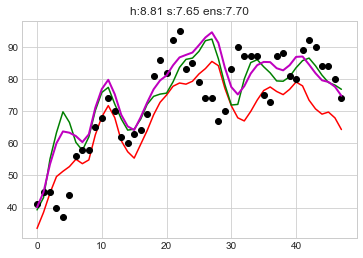

In [13]:
plot_ensemble(210)



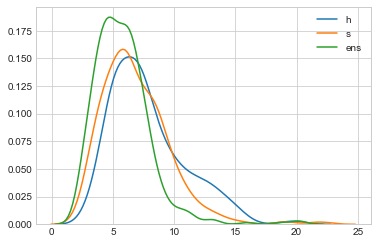

In [14]:
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')


In [15]:
model = Sequential()
model.add(Dense(units=3, activation='sigmoid', input_dim=2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])
model.fit(np.vstack((h.flatten(),s.flatten())).transpose(), m_fc.flatten())


ValueError: You are passing a target array of shape (20640, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.